In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [4]:
!ls

datalab  drive


In [0]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
#from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

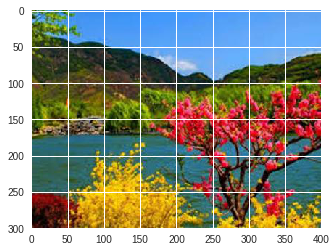

In [78]:
cont_img = scipy.misc.imread("drive/Computer Vision_Neural Styler/kashmir_1.jpg")
imshow(cont_img)

In [117]:
cont_img.shape

(1, 300, 400, 3)

In [0]:
def cost_of_content(C_dim, G_dim):
  m, n_H, n_W, n_C = G_dim.get_shape().as_list()
  C_dim_changed= tf.transpose(tf.reshape(C_dim, [-1]))
  G_dim_changed = tf.transpose(tf.reshape(G_dim, [-1]))
  
  content_cost = tf.reduce_sum((C_dim_changed - G_dim_changed)**2) / (4 * n_H * n_W * n_C)
  return content_cost

In [81]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    C_dim_changed = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    G_dim_changed = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    content_cost = cost_of_content(C_dim_changed, G_dim_changed)
    print("Cost of Content is " + str(content_cost.eval()))

Cost of Content is 6.7655935


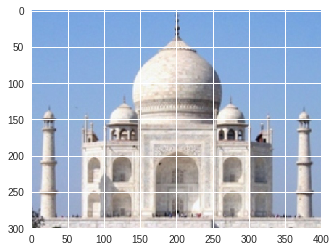

In [82]:
style_image = scipy.misc.imread("drive/Computer Vision_Neural Styler/tajmahal_2.jpg")
imshow(style_image)

In [83]:
style_image.shape

(300, 400, 3)

In [0]:
def cost_of_style_layer(S_dim, G_dim):
  m, n_H, n_W, n_C = G_dim.get_shape().as_list()
  S_dim = tf.reshape(S_dim, [n_H*n_W, n_C])
  G_dim = tf.reshape(G_dim, [n_H*n_W, n_C])
  
  GS = tf.matmul(tf.transpose(S_dim), S_dim)
  GG = tf.matmul(tf.transpose(G_dim), G_dim)
  
  Style_cost = tf.reduce_sum((GS - GG)**2) / (4 * n_C**2 * (n_W * n_H)**2)
  
  return Style_cost

In [85]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    S_dim = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    G_dim = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    Style_cost = cost_of_style_layer(S_dim, G_dim)
    
    print("Cost of Style is " + str(Style_cost.eval()))

Cost of Style is 9.190278


In [0]:
STYLE_LAYERS = [
    ('conv1_1', 0.1),
    ('conv2_1', 0.2),
    ('conv3_1', 0.3),
    ('conv4_1', 0.3),
    ('conv5_1', 0.4)]

In [0]:
def cost_of_style(model, STYLE_LAYERS):
  J=0
  for layer, value in STYLE_LAYERS:
    ip_layer = model[layer]
    S_dim = sess.run(ip_layer)
    G_dim = ip_layer
    cost_of_style_lyr = cost_of_style_layer(S_dim, G_dim)
    J= J + value * cost_of_style_lyr
    
  return J
    

In [88]:
alpha = 10 
beta = 40
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    content_cost = np.random.randn()    
    J = np.random.randn()
    J_tot = alpha * content_cost + beta * J
    print("Total content + style cost is  = " + str(J_tot))

Total content + style cost is  = 35.34667875478276


In [0]:
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [0]:
ct="drive/Computer Vision_Neural Styler/kashmir_1.jpg"
st="drive/Computer Vision_Neural Styler/tajmahal_2.jpg"

In [0]:
def reshape_and_normalize_image(image):
    """
    Reshape and normalize the input image (content or style)
    """
    
    # Reshape image to mach expected input of VGG16
    image = np.reshape(image, ((1,) + image.shape))
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    # Substract the mean to match the expected input of VGG16
    image = image - MEANS
    
    return image

In [0]:
cont_img=reshape_and_normalize_image(cont_img)

In [93]:
cont_img.shape

(1, 300, 400, 3)

In [94]:
style_image = reshape_and_normalize_image(style_image)
style_image.shape

(1, 300, 400, 3)

In [0]:
def generate_noise_image(cont_img, noise_ratio = 0.6):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, 300, 400, 3)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + cont_img * (1 - noise_ratio)
    
    return input_image

In [0]:
noisy_content__image = generate_noise_image(cont_img)


In [0]:
def Load_vgg_model(path):
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        #assert layer_name == expected_layer_name
        #return W, b

        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, 300, 400, 3)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph


In [0]:
model = Load_vgg_model("drive/Computer Vision_Neural Styler/imagenet-vgg-verydeep-19.mat")

In [0]:
sess.run(model['input'].assign(cont_img))
output = model['conv4_2']
C_dim = sess.run(output)
G_dim = output
Final_content_cost = cost_of_content(C_dim, G_dim)

In [0]:
sess.run(model['input'].assign(style_image))
Final_cost_style= cost_of_style(model, STYLE_LAYERS)

In [0]:
alpha = 20 
beta = 30
Final_total_cost = alpha * Final_content_cost + beta * Final_cost_style

In [0]:
optimizer = tf.train.AdamOptimizer(2.0)

In [0]:
train_step = optimizer.minimize(Final_total_cost)

In [0]:
def save_image(path, image):
    
    # Un-normalize the image so that it looks good
    image = image + np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    
    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

In [0]:
def Art_neural_model(sess, ip):
  iter = 2000
  sess.run(tf.global_variables_initializer())
  sess.run(model['input'].assign(ip))
  
  for k in range(iter):
    dk = sess.run(train_step)
    generated_image = sess.run(model['input'])
    
    if k%100 == 0:
      
      a,b,c = sess.run([Final_total_cost, Final_content_cost, Final_cost_style])
      print("Iteration number: " + str(k) + " :")
      print("Total cost after these iterations = " + str(a))
      print("content cost after these iterations= " + str(b))
      print("style cost after these iterations= " + str(c))
      save_image("drive/Computer Vision_Neural Styler/Output_images_3/" + str(k) + ".png", generated_image)

      
  save_image('drive/Computer Vision_Neural Styler/Output_images_3/Final_generated_image.jpg', generated_image)
  return generated_image

In [116]:
Art_neural_model(sess,noisy_content__image)

Iteration number: 0 :
Total cost after these iterations = 5462631000.0
content cost after these iterations= 11229.225
style cost after these iterations= 182080210.0
Iteration number: 100 :
Total cost after these iterations = 402143800.0
content cost after these iterations= 23747.146
style cost after these iterations= 13388962.0
Iteration number: 200 :
Total cost after these iterations = 151147180.0
content cost after these iterations= 25304.59
style cost after these iterations= 5021369.5
Iteration number: 300 :
Total cost after these iterations = 82352504.0
content cost after these iterations= 26122.227
style cost after these iterations= 2727668.5
Iteration number: 400 :
Total cost after these iterations = 53811516.0
content cost after these iterations= 26630.52
style cost after these iterations= 1775963.5
Iteration number: 500 :
Total cost after these iterations = 37596484.0
content cost after these iterations= 27040.936
style cost after these iterations= 1235188.8
Iteration number: 6

array([[[[ 94.023186 , 169.96367  , 232.79596  ],
         [ 78.0506   , 140.88223  , 164.4088   ],
         [125.52568  , 203.91711  , 138.69447  ],
         ...,
         [ 12.258529 ,  80.63118  , 223.46184  ],
         [ 13.256802 , 126.28728  , 184.05212  ],
         [ 27.288887 , 126.67037  , 298.4179   ]],

        [[134.07771  , 140.9074   , 175.33083  ],
         [ 54.89884  , 127.776146 , 175.44002  ],
         [ 94.37617  , 115.143776 , 202.72815  ],
         ...,
         [ 29.740995 ,  79.72105  , 147.72432  ],
         [ 38.41368  ,  83.27435  , 108.20455  ],
         [ 19.046925 , 106.44914  , 182.75983  ]],

        [[181.15147  , 137.89957  , 147.08218  ],
         [105.300735 , 109.86833  , 151.80182  ],
         [146.6552   , 124.52588  , 161.5191   ],
         ...,
         [ 87.19487  ,  78.0827   ,  77.61448  ],
         [107.65776  ,  82.46985  ,  93.08639  ],
         [ 69.29234  ,  81.29958  , 139.23624  ]],

        ...,

        [[ 52.97857  ,  -2.599753 ,  -